In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import FinanceDataReader as fdr
from collections import defaultdict
from matplotlib.lines import Line2D
from matplotlib import font_manager as fm

df1 = pd.read_csv('tr_basic_cardl_20210101_20230630.csv') #롯데카드
df2 = pd.read_csv('tr_basic_cardh_20190101_20230630.csv') #하나카드
df3 = pd.read_csv('LIST_BT.csv') #종목코드

lottecard = df1[df1['mandata_brand_name'].isin(['HYUNDAI DEPARTMENT STORE CO LTD_ALL', 'SHINSEGAE INC_ALL'])]
hanacard = df2[df2['mandata_brand_name'].isin(['HYUNDAI DEPARTMENT STORE CO LTD_ALL', 'SHINSEGAE INC_ALL'])]
card_data = pd.merge(lottecard, hanacard, on=['transaction_date', 'mandata_brand_name'], how='outer')
card_data.to_csv('card_data_(hyundai,shinsegae).csv', index=False)

In [2]:
data = pd.read_csv('card_data_(hyundai,shinsegae).csv', parse_dates=['transaction_date'])
data['mon'] = data['transaction_date'].dt.month
data['year'] = data['transaction_date'].dt.year
monthly_data = data.groupby(['mandata_brand_name', 'year', 'mon']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
yearly_data = data.groupby(['mandata_brand_name', 'year']).agg({
    'sales_l': 'sum',
    'number_l': 'sum',
    'users_l': 'sum',
    'sales_h': 'sum',
    'number_h': 'sum',
    'users_h': 'sum'
}).reset_index()
monthly_data['sales_all_month'] = monthly_data['sales_l'] + monthly_data['sales_h']
# monthly_data['sales_all_month'] = monthly_data['sales_h']
yearly_data['sales_all_year'] = yearly_data['sales_l'] + yearly_data['sales_h']
# yearly_data['sales_all_year'] = yearly_data['sales_h']
monthly_data = pd.merge(monthly_data, yearly_data[['mandata_brand_name', 'year', 'sales_all_year']], on=['mandata_brand_name', 'year'], how='left', suffixes=('', '_right'))

monthly_data.to_csv('sales_data_(hyundai,shinsegae).csv', index=False)

In [4]:
close_data1 = pd.read_csv('h_close.csv', parse_dates=['transaction_date'])
close_data2 = pd.read_csv('s_close.csv', parse_dates=['transaction_date'])
close_prices = pd.merge(close_data1, close_data2[['transaction_date', 'Close']], on='transaction_date', how='left', suffixes=('_company1', '_company2'))
close_prices.to_csv('stock_data_(hyundai,shinsegae).csv', index=False)

In [6]:
df = pd.read_csv('sales_data_(hyundai,shinsegae).csv')

#연매출비교
dfsaleyear = df.groupby(['year', 'mandata_brand_name'])['sales_all_year'].first().reset_index()
total_sales_by_year = dfsaleyear.groupby('year')['sales_all_year'].transform('sum')
dfsaleyear['yearly_ratio'] = dfsaleyear['sales_all_year'] / total_sales_by_year
yearly_ratio = dfsaleyear.copy()
yearly_ratio['year'] +=1

#월매출비교
dfsalemon = df.groupby(['year', 'mon', 'mandata_brand_name'])['sales_all_month'].sum().reset_index()
total_sales_by_mon_year = dfsalemon.groupby(['mon', 'year'])['sales_all_month'].sum()
dfsalemon['monthly_ratio'] = dfsalemon.apply(lambda row: row['sales_all_month'] / total_sales_by_mon_year.loc[(row['mon'], row['year'])], axis=1)
monthly_ratio = dfsalemon.copy()

In [7]:
def my_strategy(row):
    year = row['year']
    mon = row['mon']
    name = row['mandata_brand_name']
    
    # 연도와 월, 그리고 기업에 해당하는 연도별 비율을 가져옵니다.
    yearly_ratio_value = yearly_ratio[(yearly_ratio['year'] == year) & (yearly_ratio['mandata_brand_name'] == name)]['yearly_ratio'].values
    # 연도와 월, 그리고 기업에 해당하는 월별 비율을 가져옵니다.
    monthly_ratio_value = monthly_ratio[(monthly_ratio['year'] == year) & (monthly_ratio['mon'] == mon) & (monthly_ratio['mandata_brand_name'] == name)]['monthly_ratio'].values
    
    # 연도별 비율과 월별 비율이 모두 존재하는지 확인
    if yearly_ratio_value.size > 0 and monthly_ratio_value.size > 0:
        # 월별 비율이 연도별 비율보다 높으면 매수
        if monthly_ratio_value[0] > yearly_ratio_value[0]:
            return 'buy'
        # 월별 비율이 연도별 비율보다 낮으면 매도
        elif monthly_ratio_value[0] < yearly_ratio_value[0]:
            return 'sell'
        # 비율이 같으면 보유
        else:
            return 'hold'
    else:
        # 데이터가 없는 경우
        return 'no data'

# apply 메서드를 사용하여 새로운 열을 생성합니다.
monthly_ratio['active'] = monthly_ratio.apply(my_strategy, axis=1)
monthly_ratio

monthly_ratio = monthly_ratio[monthly_ratio['active'] != 'no data']
sell_previous = monthly_ratio[monthly_ratio['active'] == 'buy']
sell_current = monthly_ratio[monthly_ratio['active'] == 'sell']
merged = sell_current.merge(sell_previous, how='outer', indicator=True)
changed_rows = merged[merged['_merge'] == 'right_only']
result = changed_rows.drop(columns=['_merge'])

def find_changed_rows(result, mandata_brand_name):
    changed_rows = result[result[mandata_brand_name] != result[mandata_brand_name].shift()]
    
    return changed_rows

changed_name_rows = find_changed_rows(result, 'mandata_brand_name')

In [8]:
changed_name_rows = changed_name_rows.copy()  # 데이터프레임의 복사본 생성
changed_name_rows['date'] = pd.to_datetime(changed_name_rows['year'].astype(str) + '-' + changed_name_rows['mon'].astype(str))
changed_name_rows['date'] = changed_name_rows['date'] + pd.offsets.BMonthEnd()
changed_name_rows['date'] = pd.to_datetime(changed_name_rows['date'])

#바꿀 부분
changed_name_rows.at[65, 'date'] = '2021-12-30'
changed_name_rows

,year,mon,mandata_brand_name,sales_all_month,monthly_ratio,active,date
42,2020,1,SHINSEGAE INC_ALL,2.963949e+10,0.592182,buy,2020-01-31
43,2020,2,HYUNDAI DEPARTMENT STORE CO LTD_ALL,1.331284e+10,0.433534,buy,2020-02-28
54,2021,1,SHINSEGAE INC_ALL,5.424035e+10,0.620815,buy,2021-01-29
56,2021,3,HYUNDAI DEPARTMENT STORE CO LTD_ALL,4.104488e+10,0.496055,buy,2021-03-31
61,2021,8,SHINSEGAE INC_ALL,4.340407e+10,0.557773,buy,2021-08-31
63,2021,10,HYUNDAI DEPARTMENT STORE CO LTD_ALL,4.552625e+10,0.477472,buy,2021-10-29
65,2021,12,SHINSEGAE INC_ALL,6.572312e+10,0.581486,buy,2021-12-30
79,2023,2,HYUNDAI DEPARTMENT STORE CO LTD_ALL,3.886191e+10,0.429560,buy,2023-02-28
81,2023,4,SHINSEGAE INC_ALL,6.393854e+10,0.604905,buy,2023-04-28
83,2023,6,HYUNDAI DEPARTMENT STORE CO LTD_ALL,4.354291e+10,0.430442,buy,2023-06-30


In [9]:
buy_dates = []
sell_dates = []

# 마지막 매도일 설정
last_sell_date = '2023-07-31'

for i in range(len(changed_name_rows) - 1):  # 마지막 값은 제외
    buy_date = changed_name_rows.iloc[i]['date']
    sell_date = changed_name_rows.iloc[i + 1]['date']
    buy_dates.append(buy_date)  # 매수 날짜를 buy_dates 리스트에 추가
    sell_dates.append(sell_date)  # 매도 날짜를 sell_dates 리스트에 추가

# changed_name_rows의 마지막 행에 해당하는 매수 날짜를 buy_dates 리스트에 추가
last_buy_date = changed_name_rows.iloc[-1]['date']
buy_dates.append(last_buy_date)

# sell_dates 리스트에서 마지막 값을 제거하고 last_sell_date를 추가
sell_dates.append(last_sell_date)  # last_sell_date를 추가

In [10]:
buy_dates

[Timestamp('2020-01-31 00:00:00'),
 Timestamp('2020-02-28 00:00:00'),
 Timestamp('2021-01-29 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00'),
 Timestamp('2021-10-29 00:00:00'),
 Timestamp('2021-12-30 00:00:00'),
 Timestamp('2023-02-28 00:00:00'),
 Timestamp('2023-04-28 00:00:00'),
 Timestamp('2023-06-30 00:00:00')]

In [11]:
sell_dates

[Timestamp('2020-02-28 00:00:00'),
 Timestamp('2021-01-29 00:00:00'),
 Timestamp('2021-03-31 00:00:00'),
 Timestamp('2021-08-31 00:00:00'),
 Timestamp('2021-10-29 00:00:00'),
 Timestamp('2021-12-30 00:00:00'),
 Timestamp('2023-02-28 00:00:00'),
 Timestamp('2023-04-28 00:00:00'),
 Timestamp('2023-06-30 00:00:00'),
 '2023-07-31']

In [12]:
buy_dates = []
sell_dates = []

last_sell_date = '2023-07-31'

for i in range(len(changed_name_rows) - 1): 
    buy_date = changed_name_rows.iloc[i]['date']
    sell_date = changed_name_rows.iloc[i + 1]['date']
    buy_dates.append(buy_date) 
    sell_dates.append(sell_date)  

# 마지막에 뭘 사는지 에 따라 달라짐
last_buy_date = changed_name_rows.iloc[-1]['date']
buy_dates.append(last_buy_date)
sell_dates.append(last_sell_date) 

def calculate_long_profit(buy_price, sell_price):
    return (sell_price - buy_price) / buy_price * 100

def combine_profits(profit_company1, profit_company2, is_long_position):
    if is_long_position:
        return - profit_company1 + profit_company2
    else:
        return - profit_company2 + profit_company1

# 누적 수익률을 계산하는 함수 정의
def calculate_cumulative_profits(buy_dates, sell_dates, close_prices):
    cumulative_profits = []
    is_long_position = True
    previous_profit = 0  # 이전 누적 수익률

    for i in range(len(buy_dates)):
        buy_date = buy_dates[i]
        sell_date = sell_dates[i]

        buy_price_company1 = close_prices[close_prices['transaction_date'] == buy_date]['Close_company1'].values
        sell_price_company1 = close_prices[close_prices['transaction_date'] == sell_date]['Close_company1'].values
        buy_price_company2 = close_prices[close_prices['transaction_date'] == buy_date]['Close_company2'].values
        sell_price_company2 = close_prices[close_prices['transaction_date'] == sell_date]['Close_company2'].values


        buy_price_company1 = buy_price_company1[0]
        sell_price_company1 = sell_price_company1[0]
        buy_price_company2 = buy_price_company2[0]
        sell_price_company2 = sell_price_company2[0]

        profit_company1 = calculate_long_profit(buy_price_company1, sell_price_company1)
        profit_company2 = calculate_long_profit(buy_price_company2, sell_price_company2)
        combined_profit = combine_profits(profit_company1, profit_company2, is_long_position)

        # 현재 누적 수익률 계산
        current_profit = previous_profit + combined_profit
        cumulative_profits.append(current_profit)

        # 현재 누적 수익률을 이전 누적 수익률로 업데이트
        previous_profit = current_profit

        # 롱 포지션과 숏 포지션을 번갈아가며 거래
        is_long_position = not is_long_position

    return cumulative_profits

# 누적 수익률 계산
cumulative_profits = calculate_cumulative_profits(buy_dates, sell_dates, close_prices)

# 구간별 수익률 출력
for i, profit in enumerate(cumulative_profits):
    print(f"구간 {i+1} 누적 수익률: {profit:.2f}%")

구간 1 누적 수익률: -2.51%
구간 2 누적 수익률: 8.85%
구간 3 누적 수익률: 13.21%
구간 4 누적 수익률: 6.56%
구간 5 누적 수익률: -3.72%
구간 6 누적 수익률: -15.44%
구간 7 누적 수익률: -7.43%
구간 8 누적 수익률: -13.20%
구간 9 누적 수익률: -22.10%
구간 10 누적 수익률: -17.08%


In [13]:
saved_data = []
price_data_list = []

for i, (buy_date, sell_date) in enumerate(zip(buy_dates, sell_dates), start=1):
    price_data = close_prices[(close_prices['transaction_date'] >= buy_date) & (close_prices['transaction_date'] <= sell_date)].copy()
    
    first_price_company1 = price_data['Close_company1'].iloc[0]
    first_price_company2 = price_data['Close_company2'].iloc[0]
    
    price_data['return_company1'] = (price_data['Close_company1'] - first_price_company1) / first_price_company1
    price_data['return_company2'] = (price_data['Close_company2'] - first_price_company2) / first_price_company2
    
    if i % 2 == 0:  # 짝수 구간
        if len(saved_data) > 0:
            price_data['return_diff'] = price_data['return_company1'] - price_data['return_company2'] + saved_data[-1]
            saved_data.append(price_data['return_diff'].iloc[-1])
        else:
            price_data['return_diff'] = price_data['return_company1'] - price_data['return_company2']
            saved_data.append(price_data['return_diff'].iloc[-1])
    else:  # 홀수 구간
        if len(saved_data) > 0:
            price_data['return_diff'] = price_data['return_company2'] - price_data['return_company1'] + saved_data[-1]
            saved_data.append(price_data['return_diff'].iloc[-1])
        else:
            price_data['return_diff'] = price_data['return_company2'] - price_data['return_company1']
            saved_data.append(price_data['return_diff'].iloc[-1])
    

    price_data_list.append(price_data)
    print(f"구간 {i} 가격 데이터:")
    print(price_data)

    file_name = f"price_data_{i}.csv"
    price_data.to_csv(file_name, index=False)
    print(f"{file_name} 파일이 저장되었습니다.")

    print("저장된 데이터:")
    print(saved_data)

구간 1 가격 데이터:
    transaction_date  Close_company1  Close_company2  return_company1  \
244       2020-01-31           78000          267000         0.000000   
245       2020-02-03           78200          269000         0.002564   
246       2020-02-04           78300          273000         0.003846   
247       2020-02-05           77600          272500        -0.005128   
248       2020-02-06           81200          287000         0.041026   
249       2020-02-07           81400          281500         0.043590   
250       2020-02-10           80200          279500         0.028205   
251       2020-02-11           79900          283500         0.024359   
252       2020-02-12           82000          300000         0.051282   
253       2020-02-13           81100          293000         0.039744   
254       2020-02-14           79200          293000         0.015385   
255       2020-02-17           80000          296500         0.025641   
256       2020-02-18           78500  

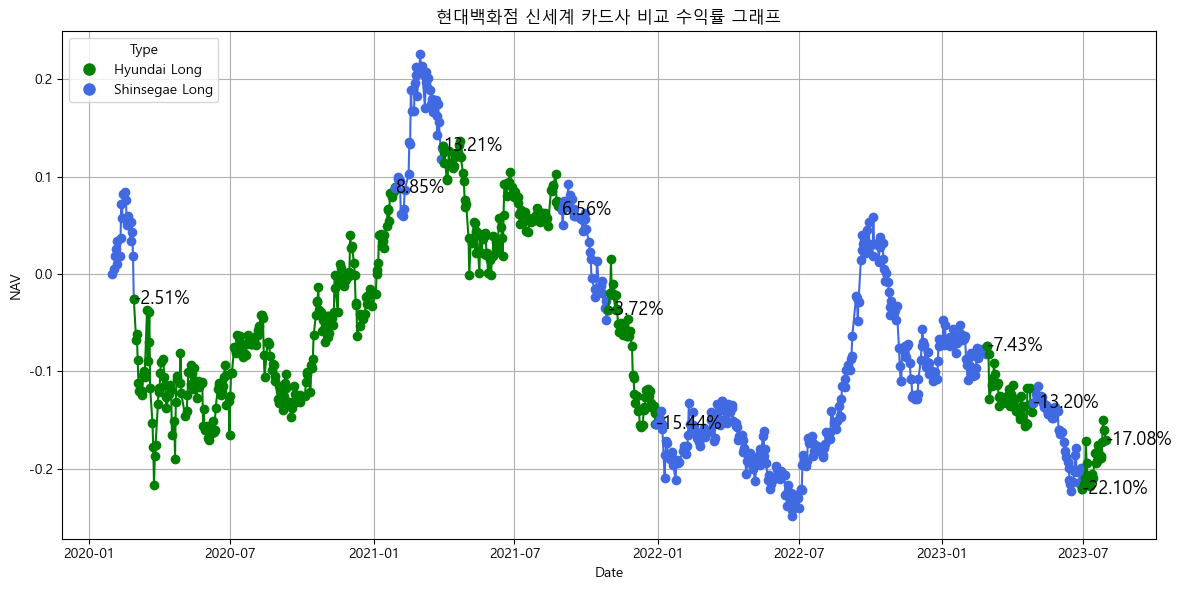

In [15]:
last_date = None
plt.rc('font', family='Malgun Gothic') 
plt.rc('axes', unicode_minus=False) 
colors = {'Hyundai Long': 'green', 'Shinsegae Long': 'royalblue'}  # 각 타입에 대한 색상 지정

plt.figure(figsize=(12, 6))
for i in range(1, 11):
    file_name = f"price_data_{i}.csv"
    df = pd.read_csv(file_name, parse_dates=['transaction_date'])
    df['type'] = 'Shinsegae Long' if i % 2 == 1 else 'Hyundai Long'  # 홀수는 현대 롱, 짝수는 신세계 롱
    df = df.sort_values(by='transaction_date')

    plt.plot(df['transaction_date'], df['return_diff'], color=colors[df['type'].iloc[0]], marker='o')
    last_value = df['return_diff'].iloc[-1]
    last_date = df['transaction_date'].iloc[-1]
    plt.text(last_date, last_value, f"{last_value * 100:.2f}%", fontsize=13, ha='left', va='center')


plt.xlabel('Date')
plt.ylabel('NAV')
plt.title('현대백화점 신세계 카드사 비교 수익률 그래프')
plt.grid(True)
plt.tight_layout()
plt.legend(handles=custom_legend, title='Type', loc='upper left')  # 마지막 범주 설정 추가
plt.show()
